# Kaggle Leaf Classification Challenge


In [2]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [5]:
!ls drive/'My Drive/Colab Notebooks/miniproject'

6.1-EXE-Kaggle-Leaf-Challenge.ipynb  images		    test.csv
data.pickle			     __pycache__	    train.csv
data_utils.py			     sample_submission.csv


Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [6]:
drive_path = 'drive/My Drive/Colab Notebooks/miniproject'
# images_path = r'C:\Users\G531\Documents\8 - Github\Deep-learning\6_Mini_Project\images'  # if you're folder structure is as defined above and you want to run locallyb

In [7]:
import sys
sys.path.append(drive_path) # Allow us to import shared custom 
#                                         # libraries, like utils.py
import data_utils

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [8]:
image_paths = glob.glob('drive/My Drive/Colab Notebooks/miniproject/images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv(drive_path + '/train.csv')
train_images = ['drive/My Drive/Colab Notebooks/miniproject/images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(drive_path + '/test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [9]:
# Your code here:
# Samples: 
train_samples = train.shape[0]
test_samples = test.shape[0]

train_col = train.columns.unique()
train_number = len(train_col)
test_col  = test.columns.unique()
train_number = len(test_col)


# Additional information
additional_info = train_col.symmetric_difference(test_col)

amount_species = len(train['species'])
unique_species =  len(train['species'].unique())

# Number of samples for each specie:
train.groupby('species').count()['id']
num_samples = set(train.groupby('species').count()['id'])

# Number of samples by spices
if len(set(train.groupby('species').count()['id'])) > 1:
  print('There are species with different amount of samples')
else:
  print(f'All species have the same number of samples: {num_samples}')



idx = []
for w in train_col:
  a = "".join([s for s in [*w] if not s.isdigit()])
  if a not in idx:
    idx.append(a)



print(f'Number of train samples: {train_samples}')
print(f'Number of test samples: {test_samples}')
print(f'Additional information in Train data: {additional_info}')
print(f'Amount of samples for specie: {num_samples}')


All species have the same number of samples: {10}
Number of train samples: 990
Number of test samples: 594
Additional information in Train data: Index(['species'], dtype='object')
Amount of samples for specie: {10}


 * **Answer:**

 * The number of sample on the training set is 990
* The number of sample on the test set is 594
* The number of features on the training set is 194
* The number of features on the test set is 193
* The column missing on the test set is species
* There is 99 Different species on the test set with 10 sample for each of those species.

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

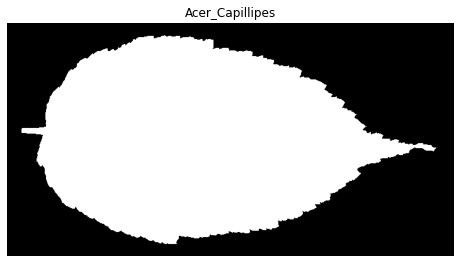

In [10]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(drive_path + '/images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

In [11]:
import time 
a = 0

times = []
while len(times) < 10:
  start = time.time()
  for i in range(10000):
    a += 1
  end = time.time()
  times.append(end-start)


a = 0
times1 = []


while len(times1) < 10:
  start = time.time()
  for j in range(10):
    for i in range(1000):
      a += 1
  end = time.time()
  times1.append(end-start)

np.array(times).mean() > np.array(times1).mean()

False

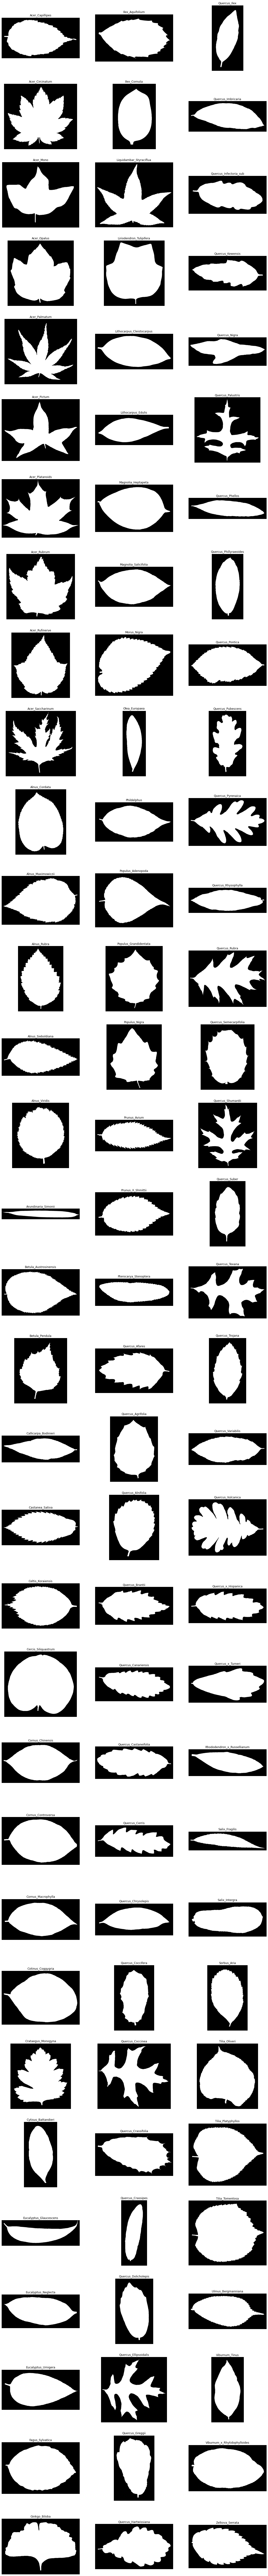

In [12]:
n = len(indexes)
n2 = 3
n1 = round(n/n2)
samples = np.array(image_paths)[indexes]
i, j = 0,0
fig, ax = plt.subplots(n1, n2, figsize=(20,200))

x = np.arange(10)
y = x*2
while (j*n1 + i) < n-1:
  for j in range(n2):
    for i in range(n1):
      image = imread(samples[j*n1 + i], as_gray=True)
      ax[i, j].imshow(image, cmap='gray')
      ax[i,j].set_title("%s" % (species[j*n1+i]))
      ax[i,j].axis('off')

plt.show()



As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

(-0.5, 633.5, 277.5, -0.5)

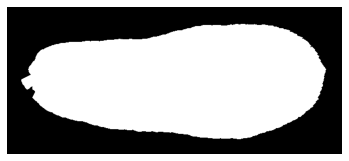

In [13]:
idx = np.where(species == 'Salix_Intergra')
im = imread(samples[idx][0], as_gray='gray')
plt.imshow(im, cmap='gray')
plt.axis('off')


## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**

 * The best fitt seems to be around 55-65 but it shhould be tested in the net


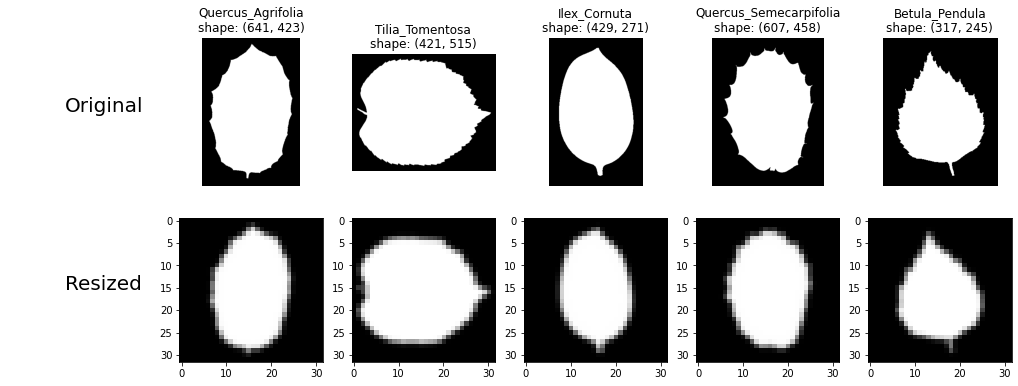

In [14]:
## Image pre-processing
image_size = (32, 32)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

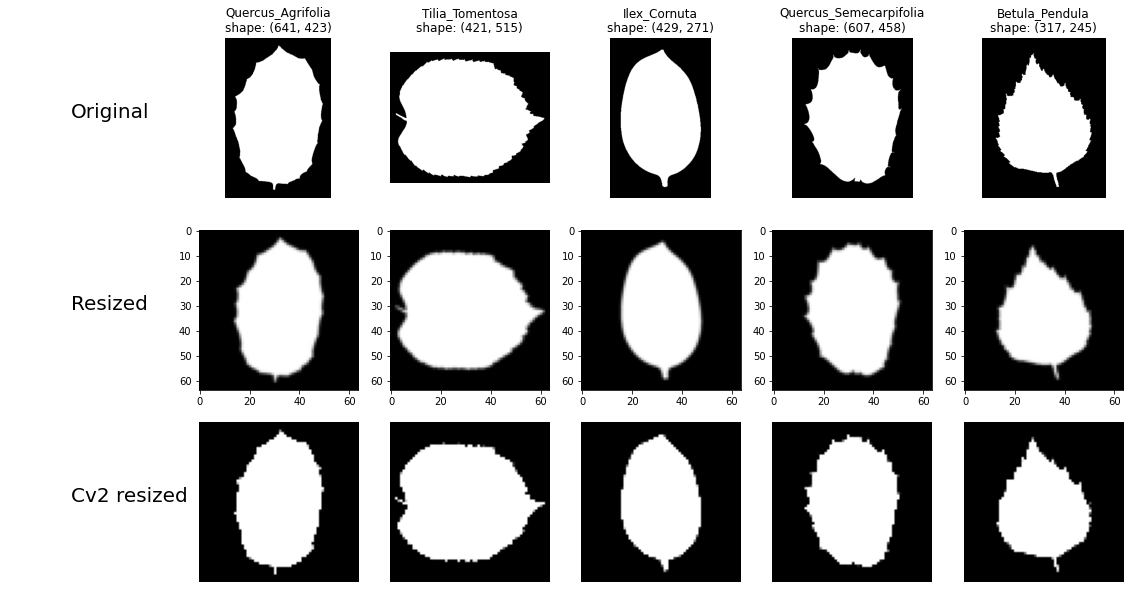

In [15]:
import cv2 
image_size = (64, 64)
n = len(image_sample)
# Create figure 
fig, ax = plt.subplots(3, n+1,figsize=(20,10))

# Original 
ax[0,0].axis('off')
txt1 = ax[0,0].text(0.4, 0.5, 'Original', fontsize=20)
txt1.set_clip_on(False)

# Resized 
ax[1,0].axis('off')
txt = ax[1,0].text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)

# Open Cv 
ax[2,0].axis('off')
txt = ax[2,0].text(0.4, 0.5, 'Cv2 resized', fontsize=20)
txt.set_clip_on(False)


for i, path in enumerate(image_sample):
  # Load Image 
  image = imread(path, as_gray=True)
  # Set title to the images
  _id = int(path.split('/')[-1].split('.')[0])
  ax[0,i+1].set_title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
  
  # Plot the original images
  ax[0,i+1].imshow(image, cmap='gray')
  ax[0,i+1].axis('equal')
  ax[0,i+1].axis('off')


  # Resize image with provided method 
  image_re = data_utils.pad2square(image)  # Make the image square
  image_re = resize(image_re, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
  ax[1,i+1].imshow(image_re, cmap='gray')
  ax[1,i+1].axis('equal')
  # ax[1,i+1].axis('off')

  # resize with open Cv
  image_recv = data_utils.pad2square(image)  # Make the image square
  image_recv = cv2.resize(image_recv, image_size)
  ax[2,i+1].imshow(image_recv, cmap='gray')
  ax[2,i+1].axis('off')


## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

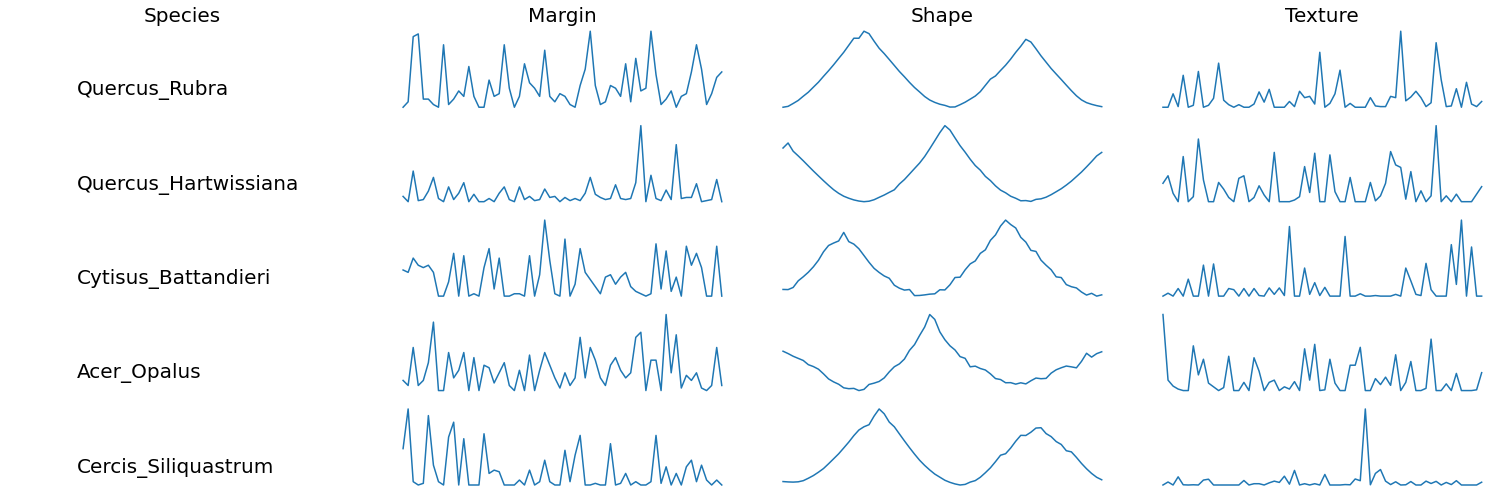

In [16]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**

 * CNN are really usefull capturing spatial information, they perserve information about one pixel and its neighbours, so they are:
  * Rotation Invariant.
  * Translation invariant 
  * Size invariant.

* I'd use CNN if I had to make a clasification using only the images. 
* I don't completely undertand the other features but it seems that margin its the boundary area around the edge, so it doesn't seem like it would need much information about the previuos data, so I would use a FFNN. 
* Textrure seems very likly to be like the margin. Captures the texture of a leaf, again FFNN.
* Shape by the other side, could store some information of the previous point. Depends on how was exctracted and what represents. If the shape feature it the coordinates of the leaf on 63 different points and then transformed into a linear space using for example Fast Fourier Transform, then might be interesting consider a RNN. 
 
 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [18]:
N = len(test.columns)
(N-1)/3

64.0

In [19]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (64,64,1)   # <-- Your answer here
NUM_CLASSES = 99   # <-- Your answer here 

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES =  64 # <-- Your answer here

In [20]:
# Paths to data
TRAIN_PATH = drive_path + "/train.csv" 
TEST_PATH = drive_path + "/test.csv" 
IMAGE_PATHS = glob.glob(drive_path + "/images/*.jpg")

# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 64, 64, 1)0.280225
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 64, 64, 1)	0.280508
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [21]:
import pickle

# Dump the data into a pickle file
with open(drive_path + '/data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [22]:
# # Load the data from a pickle file
# with open(drive_path + '/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:** 
 
A batch it's nothing else than a group of examples packed together in an arraly like. Hence, the batch size it's just indicating how many examples we are packing together. 
Specifically when computing the gradient loss on a NN we are storing the following parameters in memory:

* Parameters — The weights and biases of the network.
* Optimizer’s variables — Per-algorithm intermediate variables (e.g. momentums).
* Intermediate calculations — Values from the forward pass that are temporarily stored in GPU memory and then used in the backward pass. (e.g. the activation outputs of every layer are used in the backward pass to calculate the gradients)
* Workspace — Temporary memory for local variables of kernel implementations.

When choosing the batch size we are basically choosing between 3 options:
* Large batch size. If batch size it's the same as the number of training data it's like we were using all the data as a single batch. We denominate it ***Batch gradient descent***
  * Memory: Therefore, if the batch size is bigger we'll have more parameters to store in memory before updating them. That means that if the batch size is bigger we'll run out of memory very easily.
  **Training speed:** We only update the model once at the end. We save a lot of process time. Instead of making tinny steps we are making bigger steps on the decrease direcction. 
  * **Estimate of the gradients:** As we are using the entire data set to updat the gradients we are smoothing all the possible noise in the data and creating stable adjustments. The problem may be that we are preventing the model to obtain a suboptimal solution. 

* Using a single exammple to update the gradients, that means the batch size is one. We call that ***Stochastic gradient descent (SDG)*** 
  * Memory: We won't havce memory constarins as we are not storing a bunch of variables and we'll obtain immediante feedback.
  **Training speed:** We are updating the model in every single point. That we'll make a lot of operations, which will translate to a lot of process time. We'll make very little steps towards the minimum loss. We can see it as making a lot of small step.
  * **Estimate of the gradients:** As we are updating in each point, we'll make our model very susceptible to noise (if one data point just noise we'll also update our gradient with that point). 
* Using something in between. Batch grater than 1 and less than the number of training points. We call that ***Mini-batch Gradient Descent***


Wraping up, the smaller the batch size is, the more steps will make and more random those steps will be. However, it will also use less memory and propagate faster. The typical values goes, depending on the CPU/ GPU, from 16 to 512, being each value a potency of 2. 

In [23]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 64, 64, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [24]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [25]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [26]:
IMAGE_SHAPE, NUM_FEATURES*64*

((64, 64, 1), 64)

In [28]:
from torch.nn.modules.rnn import RNN
height, width, channels = IMAGE_SHAPE

# Structure: Convolution (we create Kernels) + concatenate features + RNN + FFNN

# Convolution 
conv_out_channels = 10  # <-- Filters in your convolutional layer
kernel_size = 3       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 1       # <-- Padding
dropout = 0.3
# Features out from the convolutional neural network, Output of the CNN
features_cnn_out =  height*width*conv_out_channels


# RNN 
hidden_size = 64
num_rnn_attr = 2
RNN_in = 64 
RNN_out = 128 # Number of units in, number of units hidden. The number of units in it's the same as trhe shape of the feature vector we are going to use. 
features_rnn_out = NUM_FEATURES*hidden_size*num_rnn_attr

# Vectors added
margin, texture, shape = 64, 64, 64 
# Using only Margin and texture 
feature_vec = margin + texture

features_cat_size = features_cnn_out + RNN_out + feature_vec

# FFNN part 
FFNN = [features_cat_size, 256, NUM_CLASSES]  # Number of features in, number of units hidden layer unit 1, number of classes 
# Keep track of features to output layer
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN
          # CONVOLUTIONAL PART 
          # First convolution, Kernel
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        # RNN part 
          # Exercise: Add a recurrent unit like and RNN or GRU
          
          # We set the input size to 64 as we are going to use one margin, shape or texture as input
        self.rnn_1 = nn.LSTM(
            input_size=RNN_in,
            hidden_size=RNN_out,
            num_layers=1,
            batch_first=True,
        )
       
        # FFNN (Dense layer )
          # Use the output from the RNN 
        self.FFNN_in= Linear(in_features=FFNN[0],
                                 out_features=FFNN[1],
                                 bias=True)
      
        self.l_out = Linear(in_features=FFNN[1],
                            out_features=FFNN[2],
                            bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        # Initialize the hidden state of the RNN
        # hidden_state = torch.zeros((2,x_shape.shape[0],50), requires_grad=True).cuda()
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # CNN
        x_img = x_img.view(-1, channels, height, width)

        x_img = self.conv_1(x_img)
        x_img = elu(x_img)

        features_img = x_img.view(-1, features_cnn_out)

        # Append features to the list "features"
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        features_vector = x
        features.append(features_vector)
        

        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer

        # >> YOUR CODE HERE <<        x = torch.cat((x_shape, x_texture), dim=1)  # if you want to use features as feature vectors
        x = x.view(batch_size, -1, 1)
        features_rnn, (h, c) = self.rnn_1(x)
        features_rnn = features_rnn.view(-1, self.rnn_1.hidden_size*num_rnn_attr*NUM_FEATURES) 

        # Append features to the list "features"
        features.append(features_rnn)
        
        # Dense layer
        features_final = torch.cat(features, dim=1)
        features_final = self.FFNN_in(features_final)
        features_final = relu(features_final)
       
        
        out['out'] = self.l_out(features_final) 
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rnn_1): LSTM(64, 128, batch_first=True)
  (FFNN_in): Linear(in_features=41216, out_features=256, bias=True)
  (l_out): Linear(in_features=256, out_features=99, bias=False)
)


In [32]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 8 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
maxpool_size = 2      # <-- Max Pool
hidden_size = 64      # <-- size of hidden state
num_rnn_attr = 2      # <-- Number of attributes in the RNN
 
# Keep track of features to output layer
def conv_out_dimension(input_dim):
  return ((input_dim + 2*conv_pad - kernel_size)//conv_stride + 1)

conv_out_dim_total = conv_out_dimension(width)//maxpool_size
out_conv_features = 2*conv_out_channels*(conv_out_dimension(conv_out_dim_total)//maxpool_size)**2

out_rnn_features = NUM_FEATURES*hidden_size*num_rnn_attr

features_cat_size = out_conv_features + out_rnn_features + 128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #First convolutional layer
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        self.conv_bn_1=nn.BatchNorm2d(conv_out_channels)
        self.conv_dropout_1 = nn.Dropout2d()     
        self.max_pool_1 = nn.MaxPool2d(kernel_size = 2)

        #Second convolutional layer
        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                             out_channels = 2*conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        self.conv_bn_2=nn.BatchNorm2d(2*conv_out_channels)
        self.conv_dropout_2 = nn.Dropout2d()
        self.max_pool_2 = nn.MaxPool2d(kernel_size = 2)


        # Exercise: Add a recurrent unit like and RNN or GRU
        # Recurrent Neural Layer        
        self.rnn_1 = nn.LSTM(input_size=1,
                             hidden_size=hidden_size,
                             num_layers=1,
                             bidirectional=False)
        
        # Dense layer
        self.l_hidden = Linear(in_features=features_cat_size,
                               out_features=256,
                               bias=True)
        self.l_hidden_bn = nn.BatchNorm1d(256)
        self.l_dropout = nn.Dropout()
        
        # Linear output layer        
        self.l_out = Linear(in_features=256,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        x_img = x_img.view(-1, channels, height, width)

        x_img = self.conv_1(x_img)
        x_img = self.conv_bn_1(x_img)
        x_img = self.conv_dropout_1(x_img)
        x_img = self.max_pool_1(x_img)
        x_img = elu(x_img)

        x_img = self.conv_2(x_img)
        x_img = self.conv_bn_2(x_img)
        x_img = self.conv_dropout_2(x_img)
        x_img = self.max_pool_2(x_img)
        x_img = elu(x_img)

        features_img = x_img.view(-1, out_conv_features)

        # Append features to the list "features"
        features.append(features_img)
              
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        features_vector = x
        features.append(features_vector)
        
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer

        # >> YOUR CODE HERE <<
        x = torch.cat((x_shape, x_texture), dim=1)  # if you want to use features as feature vectors
        x = x.view(batch_size, -1, 1)
        features_rnn, (h, c) = self.rnn_1(x)
        features_rnn = features_rnn.view(-1, self.rnn_1.hidden_size*num_rnn_attr*NUM_FEATURES) 

        # Append features to the list "features"
        features.append(features_rnn)
        
        # Dense layer
        features_final = torch.cat(features, dim=1)
        features_final = self.l_hidden(features_final)
        features_final = relu(features_final)
        features_final = self.l_hidden_bn(features_final)
        features_final = self.l_dropout(features_final)
        features_final = relu(features_final)
        
        ## Output layer where all features are in use ##       
        out['out'] = self.l_out(features_final) 
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv_bn_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_dropout_1): Dropout2d(p=0.5, inplace=False)
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_bn_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_dropout_2): Dropout2d(p=0.5, inplace=False)
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn_1): LSTM(1, 64)
  (l_hidden): Linear(in_features=11024, out_features=256, bias=True)
  (l_hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_dropout): Dropout(p=0.5, inplace=False)
  (l_out): Linear(in_features=256, out_features=99, bias=False)
)


# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [33]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss() # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [34]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

_x_shape.shape
# test the forward pass
# output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
# output['out']

torch.Size([64, 64])

# Train

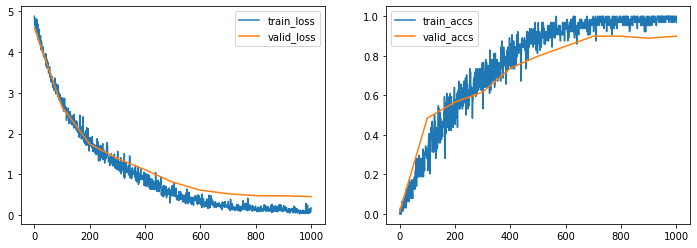

In [35]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [38]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = softmax(output['out'], dim=1).data.cpu()

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [39]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,5.297889e-08,7.749280e-07,4.266539e-09,0.000023,3.281281e-08,2.347016e-09,9.081751e-10,1.399718e-08,6.913075e-07,...,1.685581e-10,2.671297e-09,4.453836e-06,5.806429e-09,2.313894e-08,1.319826e-08,1.225306e-09,2.601513e-05,7.924931e-10,6.263283e-09
1,7,9.632166e-08,2.747672e-07,2.766062e-06,0.000006,2.677783e-08,2.258061e-06,5.427830e-07,8.861103e-08,1.265551e-07,...,6.195528e-08,2.037762e-04,1.975046e-08,2.288278e-07,5.566524e-07,1.233939e-06,5.604410e-06,2.740597e-06,8.055598e-07,2.536670e-03
2,9,1.699164e-04,4.362941e-01,1.530803e-04,0.003730,2.204932e-02,9.329816e-04,1.140562e-02,1.292493e-03,1.771522e-03,...,1.305221e-04,1.756012e-04,2.171662e-04,4.547538e-03,3.633464e-04,1.273371e-02,5.482643e-05,1.315984e-04,2.064169e-04,6.325854e-05
3,12,6.874497e-08,1.919255e-07,1.369078e-06,0.000003,1.906235e-07,3.601708e-07,7.460151e-07,1.501850e-07,5.858687e-06,...,1.545843e-06,9.242421e-06,6.226698e-08,5.821216e-08,8.131411e-07,1.949599e-06,9.256433e-05,5.654570e-08,1.184557e-05,5.213747e-06
4,13,4.050328e-07,1.674382e-06,3.826644e-09,0.000002,5.876252e-08,5.258125e-07,2.331839e-06,2.106656e-07,1.189578e-06,...,1.253256e-06,1.056052e-09,1.849810e-03,5.788024e-06,3.291680e-04,2.354388e-04,2.174537e-06,2.493606e-08,9.998421e-07,4.681785e-08


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 